# Motivation
I'm thinking of creating a simulation of players games.
- Minutes
- Poisson FGA|minutes
- Binomial FGM|minutes

The first step is to get an idea of how many minutes a player plays in a game

In [1]:
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
# Import class
parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
class_dir = os.path.join(parent_dir, 'Scripts')
sys.path.insert(0, class_dir)
import NBAStats
import numpy as np
import datetime as dt
import pandas as pd
stats_file = os.path.join(parent_dir, 'Data', 'nba_stats.pickle')
print(stats_file)
nba_stats = pickle.load(open(stats_file, 'rb'))

C:\Users\johnn\Desktop\github\nba_stats\Data\nba_stats.pickle


In [2]:
def get_player_df(nba_stats, player, player_id=False):
    ''' Get the dataframe containing info on referenced player. If player_id=True, player id given instead of name'''
    if player_id:
        if player not in nba_stats.get_player_stats().keys():
            raise ValueError('player_id {} not found'.format(player))
        
        return nba_stats.get_player_stats()[player].sort_index(ascending=False)
    else:
        if player not in nba_stats.get_player_name_id_dict().keys():
            raise ValueError('player name {} not found'.format(player))
        
        return nba_stats.get_player_stats()[nba_stats.get_player_name_id_dict()[player]].sort_index(ascending=False)

In [3]:
def player_df_convert_numeric(player_df):
    ''' Returns a dataframe that converts relevant columns to numeric 
    Columns converted:
    MIN
    '''
    player_df['MIN'] = player_df['MIN'].apply(
        lambda str_min: int(str_min[:-3]) + int(str_min[-2:])/60.0 if str_min is not None else 0 )

    return player_df

In [4]:
df_games = nba_stats.get_games()
df_games_PTS = df_games[['GAME_ID', 'TEAM_ID', 'PTS', 'OPP_PTS']]
df_games_PTS['PTS_DIFF'] = df_games_PTS['PTS'] - df_games_PTS['OPP_PTS']
df_games_PTS.head()

C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,GAME_ID,TEAM_ID,PTS,OPP_PTS,PTS_DIFF
0,0021800001,1610612738,105,87,18
1,0021800002,1610612744,108,100,8
2,0021800002,1610612760,100,108,-8
3,0021800001,1610612755,87,105,-18
0,0021800005,1610612763,83,111,-28


In [5]:
player_name = 'Stephen Curry'
player_id = nba_stats.get_player_name_id_dict()[player_name]
df_player = player_df_convert_numeric(nba_stats.get_player_stats()[player_id].copy())
df_player = df_player[df_player['MIN'] > 0]

In [6]:
df_player_team_pts = df_player.reset_index().merge(df_games_PTS, on=['GAME_ID', 'TEAM_ID'])
df_player_team_pts = df_player_team_pts[['Date', 'GAME_ID', 'TEAM_ABBREVIATION', 'OPP_TEAM_ABBREVIATION',
                                         'PLAYER_ID', 'PLAYER_NAME', 'MIN', 'PTS_x', 'PTS_DIFF']]
df_player_team_pts.head()

,Date,GAME_ID,TEAM_ABBREVIATION,OPP_TEAM_ABBREVIATION,PLAYER_ID,PLAYER_NAME,MIN,PTS_x,PTS_DIFF
0,2018-10-16,0021800002,GSW,OKC,201939,Stephen Curry,36.616667,32,8
1,2018-10-19,0021800024,GSW,UTA,201939,Stephen Curry,37.133333,31,1
2,2018-10-21,0021800038,GSW,DEN,201939,Stephen Curry,39.216667,30,-2
3,2018-10-22,0021800047,GSW,PHX,201939,Stephen Curry,29.666667,29,20
4,2018-10-24,0021800062,GSW,WAS,201939,Stephen Curry,31.583333,51,22


# Correlation with points difference
I suspect that star players will player more minutes when the game is close, and be rested when the game is a blowout either way. This seems to be supported for Stephen Curry.

In [7]:
# Convert to float otherwise numeric error is raised (no idea why)
df_player_team_pts['PTS_DIFF'] = df_player_team_pts['PTS_DIFF'].apply(lambda x: float(x))
df_player_team_pts['PTS_x'] = df_player_team_pts['PTS_x'].apply(lambda x: float(x))

df_player_team_pts['PTS_DIFF_ABS'] = df_player_team_pts['PTS_DIFF'].abs()

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 7))

df_player_team_pts.plot.scatter(x='PTS_DIFF', y='MIN', alpha=0.6, ax=ax[0])
df_player_team_pts.plot.scatter(x='PTS_DIFF_ABS', y='MIN', alpha=0.6, ax=ax[1])
fig.

SyntaxError: invalid syntax (<ipython-input-7-e67b7a93ce23>, line 12)

Text(0.5,1,'Effect of player points on team win margin')

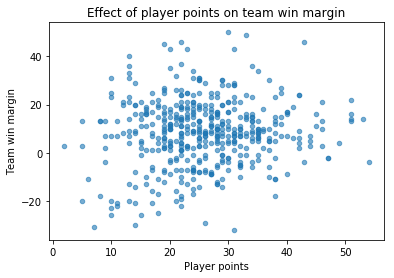

In [72]:
df_player_team_pts.plot.scatter(x='PTS_x', y='PTS_DIFF', alpha=0.6)
plt.xlabel('Player points')
plt.ylabel('Team win margin')
plt.title('Effect of player points on team win margin')

### Create a simple linear model